In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb

from datetime import datetime
import itertools
from sklearn.cluster import MeanShift, estimate_bandwidth


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [3]:
# Load Train dataset
train = pd.read_csv("data/callers.csv")
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age
0,2,32,0,27
1,4,81,0,32
2,0,41,0,22
3,1,36,0,28
4,0,55,0,31
219,1,42,1,39
220,0,38,1,28
221,2,53,1,26
222,6,69,1,21
223,2,28,1,34


In [4]:
train.calls.unique()

array([2, 4, 0, 1, 3, 5, 8, 7, 6])

In [5]:
train.calls.max(), train.calls.min()

(8, 0)

In [6]:
train.isgroup2.unique()

array([0, 1])

In [7]:
train.age.min(), train.age.mean(), train.age.max()

(19, 30.111607142857142, 43)

In [8]:
train.days_active.min(), train.days_active.mean(), train.days_active.max()

(21, 53.611607142857146, 90)

In [9]:
len(train[train.isgroup2==1])

24

In [10]:
train.head()

,calls,days_active,isgroup2,age
0,2,32,0,27
1,4,81,0,32
2,0,41,0,22
3,1,36,0,28
4,0,55,0,31


In [11]:
train['active_user'] = train['days_active'].apply(lambda x: 'True' if x <= 30 else 'False')


In [12]:
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,active_user
0,2,32,0,27,False
1,4,81,0,32,False
2,0,41,0,22,False
3,1,36,0,28,False
4,0,55,0,31,False
219,1,42,1,39,False
220,0,38,1,28,False
221,2,53,1,26,False
222,6,69,1,21,False
223,2,28,1,34,True


In [13]:
#train['call_average'] = train['isgroup2'].apply(lambda x: 1 if train[train['isgroup2']==1] else 0)
##################

train.loc[train['isgroup2'] == 1, 'call_average'] = train[train['isgroup2']==1].calls.mean()
train.loc[train['isgroup2'] != 1, 'call_average'] = train[train['isgroup2']!=1].calls.mean()



In [14]:
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,active_user,call_average
0,2,32,0,27,False,0.620000
1,4,81,0,32,False,0.620000
2,0,41,0,22,False,0.620000
3,1,36,0,28,False,0.620000
4,0,55,0,31,False,0.620000
219,1,42,1,39,False,2.666667
220,0,38,1,28,False,2.666667
221,2,53,1,26,False,2.666667
222,6,69,1,21,False,2.666667
223,2,28,1,34,True,2.666667


In [15]:
train[train['isgroup2']==1].calls.mean()

2.6666666666666665

In [16]:
train[train['isgroup2']==0].calls.mean()

0.62

In [17]:
train.columns

Index(['calls', 'days_active', 'isgroup2', 'age', 'active_user', 'call_average'], dtype='object')

In [18]:
get_dummy_columns = ['active_user']
for index in get_dummy_columns:
    train = pd.concat([train.drop(index, axis=1), pd.get_dummies(train[index], dummy_na=True, prefix=index)], axis=1) 
train.shape


(224, 8)

In [19]:
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,call_average,active_user_False,active_user_True,active_user_nan
0,2,32,0,27,0.620000,1,0,0
1,4,81,0,32,0.620000,1,0,0
2,0,41,0,22,0.620000,1,0,0
3,1,36,0,28,0.620000,1,0,0
4,0,55,0,31,0.620000,1,0,0
219,1,42,1,39,2.666667,1,0,0
220,0,38,1,28,2.666667,1,0,0
221,2,53,1,26,2.666667,1,0,0
222,6,69,1,21,2.666667,1,0,0
223,2,28,1,34,2.666667,0,1,0


In [20]:
# Replace Numpy Nan values with 0 and 'nan'
for col in train.columns:
  if train[col].dtypes == object:
    train[col].fillna(value='nan', inplace=True)
  else:
    train[col].fillna(value=0, inplace=True)

In [21]:
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,call_average,active_user_False,active_user_True,active_user_nan
0,2,32,0,27,0.620000,1,0,0
1,4,81,0,32,0.620000,1,0,0
2,0,41,0,22,0.620000,1,0,0
3,1,36,0,28,0.620000,1,0,0
4,0,55,0,31,0.620000,1,0,0
219,1,42,1,39,2.666667,1,0,0
220,0,38,1,28,2.666667,1,0,0
221,2,53,1,26,2.666667,1,0,0
222,6,69,1,21,2.666667,1,0,0
223,2,28,1,34,2.666667,0,1,0


# Automatic binning methods

In [22]:
bins_methods = [ "auto", "fd", "doane", "scott", "stone", "rice", "sturges", "sqrt"]

In [23]:
# https://stackoverflow.com/a/18364570
def get_columns_bins(column_name):
    all_bins = []

    for method in bins_methods:
        start = datetime.now()
        hist, bin_edges = np.histogram(column_name,bins=method)
        all_bins.append(bin_edges)
        print("Method : {:<7} - Running Time : {:<5} - Number of bins : {:<5} - Head : {} - Tail : {}".format(method,str(datetime.now()-start), len(bin_edges), bin_edges[:3], bin_edges[-3:-1]))
    return all_bins


In [24]:
# https://stackoverflow.com/a/18364570
def get_clustering_bins(s, quantile=0.3, n_samples=None):
    
    series = s.dropna().values.reshape(-1, 1)
    
    bandwidth = estimate_bandwidth(series, quantile=quantile, n_samples=n_samples)
    clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(series)

    d = pd.DataFrame(columns=['data_column', 'label_column'])

    d['data_column'] = series.reshape(-1)
    d['label_column'] = clustering.labels_
    
    sorted_vals = d.groupby('label_column')['data_column'].max().sort_values().values
    bins = np.insert(sorted_vals, [0] , [series.min()-1])
    bins[-1] = bins[-1] + 1
    
    return bins, range(bins.size-1)

# Apply bins to age column

In [25]:
all_bins_age = []
all_bins_age = get_columns_bins(train.age)

Method : auto    - Running Time : 0:00:00.000966 - Number of bins : 12    - Head : [19.         21.18181818 23.36363636] - Tail : [38.63636364 40.81818182]
Method : fd      - Running Time : 0:00:00.000671 - Number of bins : 12    - Head : [19.         21.18181818 23.36363636] - Tail : [38.63636364 40.81818182]
Method : doane   - Running Time : 0:00:00.000499 - Number of bins : 11    - Head : [19.  21.4 23.8] - Tail : [38.2 40.6]
Method : scott   - Running Time : 0:00:00.000372 - Number of bins : 10    - Head : [19.         21.66666667 24.33333333] - Tail : [37.66666667 40.33333333]
Method : stone   - Running Time : 0:00:00.023261 - Number of bins : 101   - Head : [19.   19.24 19.48] - Tail : [42.52 42.76]
Method : rice    - Running Time : 0:00:00.000357 - Number of bins : 14    - Head : [19.         20.84615385 22.69230769] - Tail : [39.30769231 41.15384615]
Method : sturges - Running Time : 0:00:00.000351 - Number of bins : 10    - Head : [19.         21.66666667 24.33333333] - Tail :

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:785: RuntimeWarning: The number of bins estimated may be suboptimal.
  bin_edges, uniform_bins = _get_bin_edges(a, bins, range, weights)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cluster/_mean_shift.py:235: UserWarning: Binning data failed with provided bin_size=2.181818, using data points as seeds.
  " using data points as seeds." % bin_size)


array([18.        , 21.18181818, 23.36363636, 29.90909091, 34.27272727,
       36.45454545, 40.81818182, 44.        ])

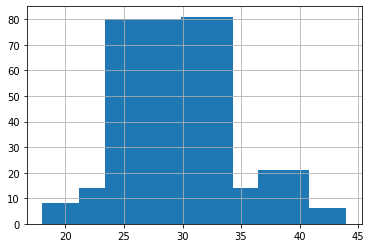

In [26]:
age_bin,label = get_clustering_bins(pd.Series(all_bins_age[0]), quantile=0.2, n_samples=10)
train.age.hist(bins=age_bin)
age_bin

In [27]:
len(age_bin) , train.age.value_counts(bins=age_bin)


(8, (29.909, 34.273]    81
 (23.364, 29.909]    80
 (36.455, 40.818]    21
 (34.273, 36.455]    14
 (21.182, 23.364]    14
 (17.999, 21.182]     8
 (40.818, 44.0]       6
 Name: age, dtype: int64)

In [28]:
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,call_average,active_user_False,active_user_True,active_user_nan
0,2,32,0,27,0.620000,1,0,0
1,4,81,0,32,0.620000,1,0,0
2,0,41,0,22,0.620000,1,0,0
3,1,36,0,28,0.620000,1,0,0
4,0,55,0,31,0.620000,1,0,0
219,1,42,1,39,2.666667,1,0,0
220,0,38,1,28,2.666667,1,0,0
221,2,53,1,26,2.666667,1,0,0
222,6,69,1,21,2.666667,1,0,0
223,2,28,1,34,2.666667,0,1,0


In [29]:
train.shape

(224, 8)

In [30]:
train['age_category'] = pd.cut(train.age, age_bin).cat.codes
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,call_average,active_user_False,active_user_True,active_user_nan,age_category
0,2,32,0,27,0.620000,1,0,0,2
1,4,81,0,32,0.620000,1,0,0,3
2,0,41,0,22,0.620000,1,0,0,1
3,1,36,0,28,0.620000,1,0,0,2
4,0,55,0,31,0.620000,1,0,0,3
219,1,42,1,39,2.666667,1,0,0,5
220,0,38,1,28,2.666667,1,0,0,2
221,2,53,1,26,2.666667,1,0,0,2
222,6,69,1,21,2.666667,1,0,0,0
223,2,28,1,34,2.666667,0,1,0,3


In [31]:
train = train.drop(columns = 'active_user_nan')

In [32]:
train.shape

(224, 8)

In [33]:
all_bins_days_active = []
all_bins_days_active = get_columns_bins(train.days_active)

Method : auto    - Running Time : 0:00:00.001291 - Number of bins : 10    - Head : [21.         28.66666667 36.33333333] - Tail : [74.66666667 82.33333333]
Method : fd      - Running Time : 0:00:00.000557 - Number of bins : 8     - Head : [21.         30.85714286 40.71428571] - Tail : [70.28571429 80.14285714]
Method : doane   - Running Time : 0:00:00.000591 - Number of bins : 11    - Head : [21.  27.9 34.8] - Tail : [76.2 83.1]
Method : scott   - Running Time : 0:00:00.000409 - Number of bins : 8     - Head : [21.         30.85714286 40.71428571] - Tail : [70.28571429 80.14285714]
Method : stone   - Running Time : 0:00:00.020400 - Number of bins : 2     - Head : [21. 90.] - Tail : [21.]
Method : rice    - Running Time : 0:00:00.000415 - Number of bins : 14    - Head : [21.         26.30769231 31.61538462] - Tail : [79.38461538 84.69230769]
Method : sturges - Running Time : 0:00:00.000492 - Number of bins : 10    - Head : [21.         28.66666667 36.33333333] - Tail : [74.66666667 82.3

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cluster/_mean_shift.py:235: UserWarning: Binning data failed with provided bin_size=7.666667, using data points as seeds.
  " using data points as seeds." % bin_size)


array([20.        , 21.        , 28.66666667, 36.33333333, 44.        ,
       67.        , 74.66666667, 91.        ])

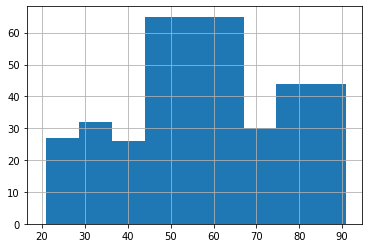

In [34]:
days_active_bin,label = get_clustering_bins(pd.Series(all_bins_days_active[0]), quantile=0.2, n_samples=10)
train.days_active.hist(bins=days_active_bin)
days_active_bin

In [35]:
len(days_active_bin) , train.days_active.value_counts(bins=days_active_bin)


(8, (44.0, 67.0]        67
 (74.667, 91.0]      44
 (28.667, 36.333]    32
 (36.333, 44.0]      29
 (67.0, 74.667]      25
 (21.0, 28.667]      23
 (19.999, 21.0]       4
 Name: days_active, dtype: int64)

In [36]:
train['days_active_category'] = pd.cut(train.days_active, days_active_bin).cat.codes
train.head(5).append(train.tail(5))

,calls,days_active,isgroup2,age,call_average,active_user_False,active_user_True,age_category,days_active_category
0,2,32,0,27,0.620000,1,0,2,2
1,4,81,0,32,0.620000,1,0,3,6
2,0,41,0,22,0.620000,1,0,1,3
3,1,36,0,28,0.620000,1,0,2,2
4,0,55,0,31,0.620000,1,0,3,4
219,1,42,1,39,2.666667,1,0,5,3
220,0,38,1,28,2.666667,1,0,2,3
221,2,53,1,26,2.666667,1,0,2,4
222,6,69,1,21,2.666667,1,0,0,5
223,2,28,1,34,2.666667,0,1,3,1


In [37]:
train.shape

(224, 9)

In [38]:
train = train.drop(columns = ['age', 'days_active'])
train.head(5).append(train.tail(5))

,calls,isgroup2,call_average,active_user_False,active_user_True,age_category,days_active_category
0,2,0,0.620000,1,0,2,2
1,4,0,0.620000,1,0,3,6
2,0,0,0.620000,1,0,1,3
3,1,0,0.620000,1,0,2,2
4,0,0,0.620000,1,0,3,4
219,1,1,2.666667,1,0,5,3
220,0,1,2.666667,1,0,2,3
221,2,1,2.666667,1,0,2,4
222,6,1,2.666667,1,0,0,5
223,2,1,2.666667,0,1,3,1


In [39]:
#Calculate correlations
corr = train.corr()
corr

,calls,isgroup2,call_average,active_user_False,active_user_True,age_category,days_active_category
calls,1.000000,0.492399,0.492399,0.156608,-0.156608,-0.191175,0.304150
isgroup2,0.492399,1.000000,1.000000,-0.089443,0.089443,0.049015,-0.061531
call_average,0.492399,1.000000,1.000000,-0.089443,0.089443,0.049015,-0.061531
active_user_False,0.156608,-0.089443,-0.089443,1.000000,-1.000000,-0.050156,0.676768
active_user_True,-0.156608,0.089443,0.089443,-1.000000,1.000000,0.050156,-0.676768
age_category,-0.191175,0.049015,0.049015,-0.050156,0.050156,1.000000,-0.041044
days_active_category,0.304150,-0.061531,-0.061531,0.676768,-0.676768,-0.041044,1.000000


In [40]:
cr = corr.copy()
top_corr_columns = []
#Determine best correlate columns over 0.1
top_corr_columns = cr.loc[:, 'calls'][:-1]
best_accurate_columns = top_corr_columns[abs(top_corr_columns) > 0.1].sort_values(ascending=False)
len(best_accurate_columns)


6

In [41]:
best_accurate_columns

calls                1.000000
call_average         0.492399
isgroup2             0.492399
active_user_False    0.156608
active_user_True    -0.156608
age_category        -0.191175
Name: calls, dtype: float64

In [42]:
#Control summary of train dataset rows summation
for index in range(train.shape[0]):
  print(train.loc[index].sum(),"****************",  train.loc[index].min(),"****************",  train.loc[index].max())


7.62 **************** 0.0 **************** 2.0
14.620000000000001 **************** 0.0 **************** 6.0
5.62 **************** 0.0 **************** 3.0
6.62 **************** 0.0 **************** 2.0
8.620000000000001 **************** 0.0 **************** 4.0
5.62 **************** 0.0 **************** 3.0
10.620000000000001 **************** 0.0 **************** 5.0
6.62 **************** 0.0 **************** 3.0
6.62 **************** 0.0 **************** 4.0
7.62 **************** 0.0 **************** 4.0
9.620000000000001 **************** 0.0 **************** 5.0
6.62 **************** 0.0 **************** 3.0
8.620000000000001 **************** 0.0 **************** 5.0
6.62 **************** 0.0 **************** 3.0
11.620000000000001 **************** 0.0 **************** 6.0
9.620000000000001 **************** 0.0 **************** 5.0
12.620000000000001 **************** 0.0 **************** 6.0
4.62 **************** 0.0 **************** 2.0
6.62 **************** 0.0 **************** 4.0

In [43]:
#Define mape method
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
column_color = ['green', 'yellow', 'brown', 'orange', 'black', 'red', 'purple']#, 'pink', 'black', 'cyan', 'magenta']


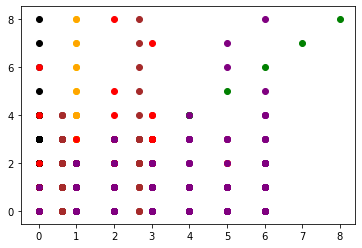

In [45]:

i=0
for column in train.columns:
  plt.scatter(train.loc[:,column], train.loc[:,"calls"], c=column_color[i])
  i = i+1

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 7 columns):
calls                   224 non-null int64
isgroup2                224 non-null int64
call_average            224 non-null float64
active_user_False       224 non-null uint8
active_user_True        224 non-null uint8
age_category            224 non-null int8
days_active_category    224 non-null int8
dtypes: float64(1), int64(2), int8(2), uint8(2)
memory usage: 6.2 KB


count    224.000000
mean       0.839286
std        1.288470
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: calls, dtype: float64


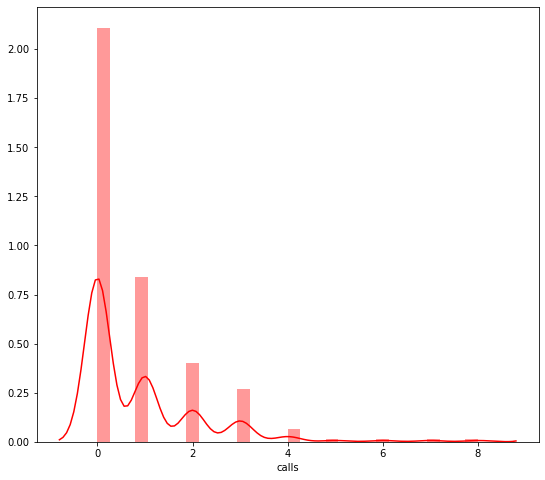

In [47]:
print(train['calls'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train['calls'], color='r', bins=30, hist_kws={'alpha': 0.4});


In [48]:
train['calls'].value_counts(normalize=False)


0    126
1     50
2     24
3     16
4      4
8      1
7      1
6      1
5      1
Name: calls, dtype: int64

In [49]:
train.apply(np.max)


calls                   8.000000
isgroup2                1.000000
call_average            2.666667
active_user_False       1.000000
active_user_True        1.000000
age_category            6.000000
days_active_category    6.000000
dtype: float64

In [50]:
train.columns

Index(['calls', 'isgroup2', 'call_average', 'active_user_False', 'active_user_True', 'age_category', 'days_active_category'], dtype='object')

In [51]:
print("Number of calls per age")

# Number of calls per age
reviews_per_age = train.groupby(["age_category"]).agg({
    "calls": pd.Series.nunique
})
reviews_per_age.describe()

Number of calls per age


,calls
count,7.000000
mean,4.142857
std,2.115701
min,1.000000
25%,3.000000
50%,4.000000
75%,5.500000
max,7.000000


In [52]:
print("Number of calls per group2")
# Number of reviews per condition
reviews_per_group2 = train.groupby(["isgroup2"]).agg({
    "calls": pd.Series.nunique
})

reviews_per_group2.describe()

Number of calls per group2


,calls
count,2.000000
mean,7.000000
std,2.828427
min,5.000000
25%,6.000000
50%,7.000000
75%,8.000000
max,9.000000


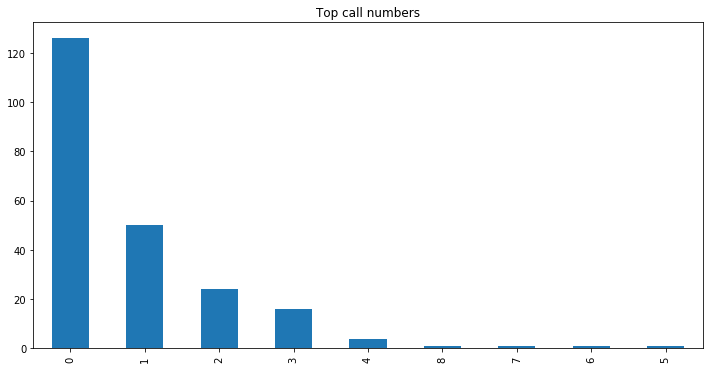

In [53]:
# Top calls
plot = train.calls.value_counts().nlargest(10).plot(kind='bar', title="Top call numbers", figsize=(12,6))


In [54]:
#Label encoder calculation
#age score
le = LabelEncoder()
le.fit(train.age_category.drop_duplicates()) 
train.age_category = le.transform(train.age_category)
# group2 or not
le.fit(train.isgroup2.drop_duplicates()) 
train.isgroup2 = le.transform(train.isgroup2)

In [55]:
train.corr()['calls'].sort_values()

age_category           -0.191175
active_user_True       -0.156608
active_user_False       0.156608
days_active_category    0.304150
isgroup2                0.492399
call_average            0.492399
calls                   1.000000
Name: calls, dtype: float64

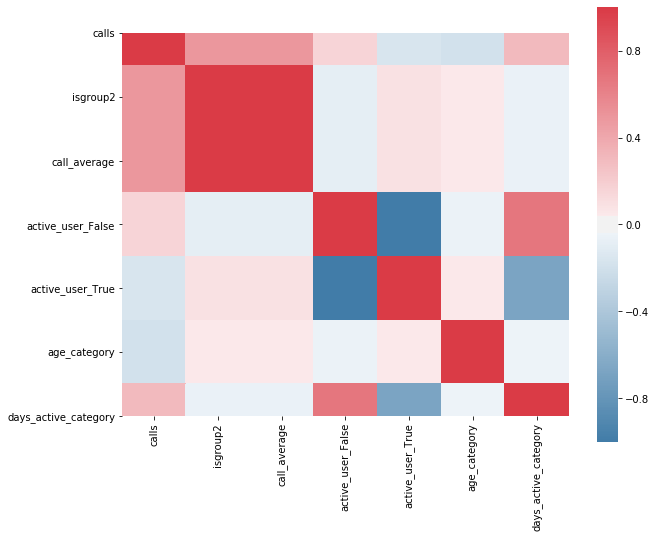

In [56]:
#heatmap deep corr graph
f, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

In [57]:
train_df = train.copy()

In [58]:
y = train_df.calls

In [59]:
X = train_df.copy()
X = X.drop(columns='calls')
X.head()

,isgroup2,call_average,active_user_False,active_user_True,age_category,days_active_category
0,0,0.62,1,0,2,2
1,0,0.62,1,0,3,6
2,0,0.62,1,0,1,3
3,0,0.62,1,0,2,2
4,0,0.62,1,0,3,4


In [60]:
X.shape, y.shape

((224, 6), (224,))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print(X_train.shape)
print(y_train.shape)

(134, 6)
(134,)


In [62]:
print(X_test.shape)
print(y_test.shape)

(90, 6)
(90,)


In [63]:
#GridSearch to determine best parameters
param_grid = {
    'n_estimators': [10, 50, 100, 250, 500, 750],
    'max_features': ['auto', 'sqrt', 'log2'],
    'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.001, 0.01, 0.1], 
    'max_depth' : [2, 4, 6, 7, 12],
    'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10]}

In [64]:
bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        param_grid,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )

In [65]:
xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=50)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2346 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 3696 tasks      | elapsed:   31.1s


[01:43:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.26959
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.26522
[2]	validation_0-rmse:1.26091
[3]	validation_0-rmse:1.25667
[4]	validation_0-rmse:1.25248
[5]	validation_0-rmse:1.24835
[6]	validation_0-rmse:1.24428
[7]	validation_0-rmse:1.24026
[8]	validation_0-rmse:1.23629
[9]	validation_0-rmse:1.23237
[10]	validation_0-rmse:1.22851
[11]	validation_0-rmse:1.22470
[12]	validation_0-rmse:1.22094
[13]	validation_0-rmse:1.21724
[14]	validation_0-rmse:1.21357
[15]	validation_0-rmse:1.20996
[16]	validation_0-rmse:1.20639
[17]	validation_0-rmse:1.20287
[18]	validation_0-rmse:1.

[247]	validation_0-rmse:0.90328
[248]	validation_0-rmse:0.90278
[249]	validation_0-rmse:0.90241
[250]	validation_0-rmse:0.90193
[251]	validation_0-rmse:0.90156
[252]	validation_0-rmse:0.90120
[253]	validation_0-rmse:0.90076
[254]	validation_0-rmse:0.90028
[255]	validation_0-rmse:0.89993
[256]	validation_0-rmse:0.89958


[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:   42.9s finished


[257]	validation_0-rmse:0.89916
[258]	validation_0-rmse:0.89870
[259]	validation_0-rmse:0.89835
[260]	validation_0-rmse:0.89802
[261]	validation_0-rmse:0.89756
[262]	validation_0-rmse:0.89723
[263]	validation_0-rmse:0.89679
[264]	validation_0-rmse:0.89646
[265]	validation_0-rmse:0.89602
[266]	validation_0-rmse:0.89570
[267]	validation_0-rmse:0.89537
[268]	validation_0-rmse:0.89495
[269]	validation_0-rmse:0.89463
[270]	validation_0-rmse:0.89421
[271]	validation_0-rmse:0.89391
[272]	validation_0-rmse:0.89350
[273]	validation_0-rmse:0.89318
[274]	validation_0-rmse:0.89288
[275]	validation_0-rmse:0.89248
[276]	validation_0-rmse:0.89217
[277]	validation_0-rmse:0.89177
[278]	validation_0-rmse:0.89149
[279]	validation_0-rmse:0.89109
[280]	validation_0-rmse:0.89081
[281]	validation_0-rmse:0.89042
[282]	validation_0-rmse:0.89013
[283]	validation_0-rmse:0.88985
[284]	validation_0-rmse:0.88947
[285]	validation_0-rmse:0.88920
[286]	validation_0-rmse:0.88895
[287]	validation_0-rmse:0.88867
[288]	va

[514]	validation_0-rmse:0.85454
[515]	validation_0-rmse:0.85449
[516]	validation_0-rmse:0.85441
[517]	validation_0-rmse:0.85431
[518]	validation_0-rmse:0.85425
[519]	validation_0-rmse:0.85418
[520]	validation_0-rmse:0.85408
[521]	validation_0-rmse:0.85404
[522]	validation_0-rmse:0.85398
[523]	validation_0-rmse:0.85391
[524]	validation_0-rmse:0.85386
[525]	validation_0-rmse:0.85379
[526]	validation_0-rmse:0.85374
[527]	validation_0-rmse:0.85364
[528]	validation_0-rmse:0.85360
[529]	validation_0-rmse:0.85353
[530]	validation_0-rmse:0.85348
[531]	validation_0-rmse:0.85343
[532]	validation_0-rmse:0.85336
[533]	validation_0-rmse:0.85332
[534]	validation_0-rmse:0.85326
[535]	validation_0-rmse:0.85319
[536]	validation_0-rmse:0.85315
[537]	validation_0-rmse:0.85305
[538]	validation_0-rmse:0.85299
[539]	validation_0-rmse:0.85294
[540]	validation_0-rmse:0.85285
[541]	validation_0-rmse:0.85281
[542]	validation_0-rmse:0.85276
[543]	validation_0-rmse:0.85269
[544]	validation_0-rmse:0.85266
[545]	va

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [66]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             max_features='auto', min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=750, n_jobs=-1, nthread=-1,
             num_parallel_tree=1, random_state=10, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=1, seed=10, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [67]:
#Set XGBRegressor parameters from gridsearchCV
final_xg_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             max_features='auto', min_child_weight=1, missing=None,
             monotone_constraints='()', n_estimators=750, n_jobs=-1, nthread=-1,
             num_parallel_tree=1, random_state=10, reg_alpha=1, reg_lambda=1,
             scale_pos_weight=1, seed=10, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [68]:
#Prediction Step
final_model =final_xg_reg.fit(X_train,y_train)
predictions = final_model.predict(X_test)

[01:43:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [82]:
final_model.save("model.hdf5")
final_model.save_model('model.model')

In [83]:
esp = load_model("model.model")


NameError: name 'load_model' is not defined

In [87]:
y_test_final = y_test.replace(0, 0.1)

In [95]:
mae = mean_absolute_error(y_test_final, predictions)
mape= mean_absolute_percentage_error(y_test_final, predictions)/len(y_test_final)

In [96]:
mae, mape

(0.7053869736856885, 3.5811428219728225)

In [97]:
predictions2 = predictions.round()

In [98]:
len(predictions2)

90

In [99]:
len(y_test_final)

90

In [ ]:
df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                   columns=['a', 'b', 'c'])